### The aim of this project is to predict the gender of an artist based on the lyrics of the artist's song

In [180]:
import re
import os
import nltk
import ftfy
import ast
import json
import math
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




%matplotlib inline

pd.options.display.max_rows = 420

### Data Collection
- BeautifulSoup is used to scrape names of artists from the billboard website
- These names are used in the Musixmatch and lyricsgenius APIs to download lyrics
- Script used is scraper.py
- Seperate files combined in combine.py

### Data Preprocessing

In [326]:
common_re = re.compile(r"[*].+[*]") #remove ******* This Lyrics is NOT for Commercial use *******
punt_re = re.compile(r"[^a-zA-Z' ]+") #irrelevant puctuations

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)

def preprocess(text):
    text = text.lower()
    p_text = common_re.sub("", text)
    p_text = punt_re.sub("", p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()  #return lyrics in the same case

def replace_apostrophe(lyrics):
    full_text = ""
    tokens = lyrics.split(" ")
    for text in tokens:
        if "'" in text:
            shortened = text.split("'")
            if shortened[1] == "ll" or text == "i'mma":
                text = shortened[0] + " will"
            elif shortened[1] == "m":
                text = shortened[0] + " am"
            elif shortened[1] == "d" or text == "'d":
                text = shortened[0] + " would"
            elif shortened[1] == "ve":
                text = shortened[0] + " have"
            elif shortened[1] == "s":
                text = shortened[0] + "s"
            elif shortened[1] == "re":
                text = shortened[0] + " are"   
            elif text == "'cause" or shortened[1] == "cause" or text == "'cuz":
                text = "because"
            elif shortened[1] == "" or shortened[0][-2:] == "in":
                text = shortened[0] + "g"
            elif text == "y'all":
                text = "you all"
            elif text == "'em" or text == " 'em":
                text = "them"
            elif text == "'lone":
                text = "alone"
            elif text == "c'mon":
                text = "common"
            elif shortened[1] == "t" and shortened != "ain":
                text = shortened[0] + " not"
        full_text = full_text + " " + text
    return full_text
          
     
def tokenise(text):
    return tokenise_re.findall(text)

nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

def stopwords_file(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

stanford_stopwords = stopwords_file("stanford_stopwords.txt")

def remove_stopwords(tokens):
    nltk_filtered = [word for word in tokens if word not in nltk_stopwords]
    return nltk_filtered

def frequency_analysis(tokens):
    freq = nltk.FreqDist(tokens)
    for key,val in freq.most_common(20):
        print(key,val,sep="\t")
    freq.plot(20, cumulative=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oyinlola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Embeddings

In [327]:
from gensim.models.word2vec import Word2Vec

In [328]:
#get data from seperate files to be use to train word embeddings
def word2vec_import_lyrics(folder):
    all_songs = []
    for item in os.listdir(folder):
        file = folder + item
        with open(file) as f:
            tracks = f.readlines()
            for track in tracks:
                if len(track) < 10 or track == "\n":
                    continue
                elif track == "":
                    continue
                else:
                    all_songs.append(track)
    return all_songs

In [329]:
word2vec_lyrics = word2vec_import_lyrics("/Users/oyinlola/Desktop/MSc Data Science/LENT TERM/SCC 413 - Applied Data Mining/Research Projects/Lyrics/word2vec/")

In [330]:
len(word2vec_lyrics)

66050

- There are 66,050 songs used to train the word2vec model

In [331]:
#preprocess
clean_word2vec_lyrics = [replace_apostrophe(track) for track in word2vec_lyrics]
clean_word2vec_lyrics = [preprocess(track) for track in clean_word2vec_lyrics]
word2vec_lyrics_corpus = [tokenise(track) for track in clean_word2vec_lyrics]
word2vec_lyrics_corpus = [remove_stopwords(tokens) for tokens in word2vec_lyrics_corpus]  #not sure this is relevant

In [332]:
len(word2vec_lyrics_corpus)

66050

In [333]:
word2vec_model = Word2Vec(word2vec_lyrics_corpus, size=200, window=10, min_count=2, workers=10, sample=0.001)

In [334]:
word2vec_model.train(documents, total_examples=len(documents), epochs=10)

(20127924, 24212860)

In [335]:
word2vec_model.wv.most_similar(positive="love", topn=10)

[('baby', 0.5489543676376343),
 ('oh', 0.4587838053703308),
 ('way', 0.45303404331207275),
 ('darling', 0.4521137475967407),
 ('never', 0.44302061200141907),
 ('feel', 0.43786388635635376),
 ('loving', 0.4273035526275635),
 ('know', 0.4238782525062561),
 ('give', 0.4083635210990906),
 ('tenderly', 0.3925415575504303)]

In [336]:
word2vec_model.wv.most_similar(positive="girl", topn=10)

[('baby', 0.47677338123321533),
 ('know', 0.39274898171424866),
 ('want', 0.36164340376853943),
 ('hice', 0.34430259466171265),
 ('sexy', 0.3401070833206177),
 ('boy', 0.33144062757492065),
 ('hook', 0.31593161821365356),
 ('alam', 0.31299349665641785),
 ('tonight', 0.2996935248374939),
 ('doggies', 0.2980412244796753)]

In [337]:
word2vec_model.wv.most_similar(positive="baby", topn=10)

[('love', 0.548954427242279),
 ('want', 0.5205880999565125),
 ('know', 0.48951292037963867),
 ('oh', 0.4860249161720276),
 ('girl', 0.47677338123321533),
 ('ooh', 0.43238550424575806),
 ('babe', 0.4235520362854004),
 ('come', 0.3816792964935303),
 ('let', 0.36125144362449646),
 ('wanna', 0.3568750321865082)]

In [338]:
word_embeddings = dict(zip(word2vec_model.wv.index2word, word2vec_model.wv.syn0))  #this is a word embedding dictionary mapping a word to a 200-dimensional vector
len(word_embedding['love'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


200

##### To do: Visualize word embeddings

### Feature Extraction

In [340]:
class Artist:
    def __init__(self, obj):
        self.gender = obj['gender']
        self.lyrics = ""
        self.tokens = []
        self.pos_list = []
        self.num_tokens = 0
        self.adj_pos_present = 0
        self.pp_pos_present = 0
        self.vb_pos_present = 0
        self.pos_fql = Counter()
        self.bigrams = Counter()
        self.trigrams = Counter()
        self.tokens_fql = Counter()
        self.pp_pos_fql = Counter()
        self.adj_pos_fql = Counter()
        self.vb_pos_fql = Counter()
        self.word_embeddings = word_embeddings
        self.dimension = 0
        
        
    tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") 
    def tokenise(self, text):
        return tokenise_re.findall(text)

    def extract_features(self, track):
        self.lyrics += track
        p_lyrics = replace_apostrophe(track) 
        p_lyrics = preprocess(p_lyrics) 
        self.lyrics = p_lyrics
        tokens = self.tokenise(p_lyrics)
        tokens = remove_stopwords(tokens)
        self.num_tokens += len(tokens)
        self.tokens.extend(tokens)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens)
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        self.bigrams.update(self.ngrams(tokens, 2))
        self.trigrams.update(self.ngrams(tokens, 3))
        self.pp_pos_fql.update(self.adjectives(self.pos_list))
        self.adj_pos_fql.update(self.personal_pronoun(self.pos_list))
        self.vb_pos_fql.update(self.verb(self.pos_list))
        self.dimension = len(next(iter(word_embeddings.items()))) #return a vector of zeros with same dimensionality as other vectors if empty
        
        
    #lexical features 
    def ngrams(self, tokens, n, sep = "_", buffer="^"):
        buffered = [buffer] * (n-1) + tokens + [buffer] * (n-1) 
        return [sep.join(buffered[i:i+n]) for i in range(len(buffered)-n+1)]
    
    def extract_features_from_lyrics(self, tracks):
        for lyrics in tracks:
            extract_features(lyrics)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens
    
    def average_word_length(self):
        avg_word_length = sum([len(tok) for tok in self.tokens])/len(self.tokens)
        return avg_word_length
    
    #Syntactic features: POS used adjectives, personal pronouns, verbs,
    def adjectives(self, pos_list):
        adj_pos = []
        for pos in pos_list:
            if pos == "JJ" or pos == "ADJ":
                adj_pos.append(pos)

        if len(adj_pos) == 0:
            self.adj_pos_present = 0
            return {"None present":0}
        else:
            self.adj_pos_present = len(adj_pos)
            return adj_pos
            
    def personal_pronoun(self, pos_list):
        pp_pos = []
        for pos in pos_list:
            if pos == "PRP":
                pp_pos.append(pos)
    
        if len(pp_pos) == 0:
            self.pp_pos_present = 0
            return {"None present":0}
        else:
            self.pp_pos_present = len(pp_pos)
            return pp_pos
    
    def verb(self, pos_list):
        vb_pos = []
        for pos in pos_list:
            if pos == "VB":
                vb_pos.append(pos)

        if len(vb_pos) == 0:
            self.vb_pos_present = 0
            return {"None present":0}
        else:
            self.vb_pos_present = len(vb_pos)
            return vb_pos
    
    def adj_present(self, tokens):
        count = len(self.adjectives(tokens))
        return count
    
    def pp_present(self, tokens):
        count = len(self.personal_pronoun(tokens))
        return count
    
    def vb_present(self, tokens):
        count = len(self.personal_pronoun(tokens))
        return count

In [341]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

In [254]:
#baseline
def get_bow(document):
    return document.tokens

def get_tokens_fql(document):
    return document.tokens_fql

def get_bigrams(document):
    return document.bigrams

def get_trigrams(document):
    return document.trigrams

def get_pos_fql(document):
    return document.pos_fql

def get_adj_fql(document):
    return document.adj_pos_fql

def get_pp_fql(document):
    return document.pp_pos_fql

def get_vb_fql(document):
    return document.vb_pos_fql

def get_adj_present(document):
    return document.adj_pos_present

def get_pp_present(document):
    return document.pp_pos_present

def get_vb_present(document):
    return document.vb_pos_present

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def get_avg_word_length(document):
    return {'avg_word_length': document.average_word_length()}

#word embeddings
def get_word_emb(document):
    return {'dim': document.dimension}

def get_mean_word_emb(document):
    mean = np.array([np.mean([document.word_embeddings[word] for word in tokens if word in document.word_embeddings]
                            or [np.zeros(document.dimension)], axis = 0)
                     for tokens in document
                    ])
    return mean

In [239]:
def import_lyrics(file, gender):
    metadata = {'gender': gender}
    with open(file) as f:
        tracks = f.readlines()
        for track in tracks:
            if len(track) < 10 or track == "\n":
                continue
            elif track == "":
                continue
            else:
                song = Artist(metadata)
                song.extract_features(track)
                if len(song.tokens) == 0:
                    continue
                yield song

In [240]:
def build_corpus(folder, gender):
    corpus = []
    files = []
    for file in os.listdir(folder):
        file = folder + file
        files.append(file)
    for file in files:
        words = import_lyrics(file, gender)
        corpus.extend(words)
    return corpus

In [255]:
corpus = []

female = build_corpus("Data/female_new/", "female")
male = build_corpus("Data/male_new/", "male")

corpus.extend(female) 
corpus.extend(male)

In [256]:
print("Female: ", len(female))
print("Male: ", len(male))

Female:  17572
Male:  23585


In [257]:
y = [d.gender for d in corpus]
X = corpus

In [245]:
adj_fql_male = [adj.adj_pos_present for adj in corpus if adj.gender=="male"]
pp_fql_male = [pp.pp_pos_present for pp in corpus if pp.gender=="male"]
vb_fql_male = [vb.vb_pos_present for vb in corpus if vb.gender=="male"]

adj_fql_female = [adj.adj_pos_present for adj in corpus if adj.gender=="female"]
pp_fql_female = [pp.pp_pos_present for pp in corpus if pp.gender=="female"]
vb_fql_female = [vb.vb_pos_present for vb in corpus if vb.gender=="female"]

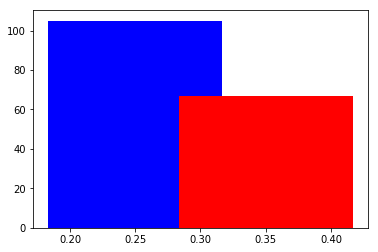

In [246]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(0.25,adj_fql_male,width,color='b',label='-Ymin')
ax.bar(0.35,adj_fql_female,width,color='r',label='Ymax')

plt.show()

In [247]:
str(set(adj_fql_male))

'{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 61, 64, 65, 66, 67, 79, 105}'

In [248]:
str(set(adj_fql_female))

'{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 50, 56, 57, 67}'

### Train Model

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

32925 8232
32925 8232


In [280]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('bow_features', Pipeline([
                ('bow_processor', DocumentProcessor(process_method = get_tokens_fql)),
                ('pos_vectorizer', DictVectorizer()),
            ])),
#              ('bigram', Pipeline([
#                 ('bigram_processor', DocumentProcessor(process_method = get_bigrams)),
#                 ('bigram_vectorizer', DictVectorizer()),
#             ])),
#             ('trigram', Pipeline([
#                 ('trigram_processor', DocumentProcessor(process_method = get_trigrams)),
#                 ('trigram_vectorizer', DictVectorizer()),
#             ])),
#             ('pos_features', Pipeline([
#                 ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
#                 ('pos_vectorizer', DictVectorizer()),
#             ])),
#             ('stats_features', Pipeline([
#                 ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
#                 ('stats_vectorizer', DictVectorizer()),
#             ])),
#             ('avg_word_length', Pipeline([
#                 ('processor', DocumentProcessor(process_method = get_avg_word_length)),
#                 ('vectorizer', DictVectorizer()),
#             ])),
#             ('adj_fql', Pipeline([
#                 ('processor', DocumentProcessor(process_method = get_adj_fql)),
#                 ('vectorizer', DictVectorizer()),
#             ])),
#             ('pp_fql', Pipeline([
#                 ('processor', DocumentProcessor(process_method = get_pp_fql)),
#                 ('vectorizer', DictVectorizer()),
#             ])),
#             ('word_emb_dim', Pipeline([
#                 ('processor', DocumentProcessor(process_method = get_word_emb)),
#                 ('vectorizer', DictVectorizer()),
#             ])),
#             ('mean_word_emb_dim', Pipeline([
#                 ('processor', DocumentProcessor(process_method = get_mean_word_emb)),
#                 ('vectorizer', DictVectorizer()),
#             ])),
        ],
    )),
#     ('selector', SelectKBest(score_func = chi2, k=20000)),
#     ('norm', TfidfTransformer()),
#     ('clf', DecisionTreeClassifier()),
    ('clf', None),
])

In [281]:
search = GridSearchCV(model, cv=StratifiedKFold(n_splits=5, random_state=0),
                     return_train_score=False,
                     scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
                     refit="f1_weighted",
                     param_grid = [
                         {
                             'clf': [LogisticRegression(solver='liblinear', random_state=0)],
                             'clf__C': [1.0, 1.5, 2.0, 2.5],
                         }
                     ])

search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('bow_features', Pipeline(memory=None,
     steps=[('bow_processor', DocumentProcessor(process_method=<function get_tokens_fql at 0x1a5d566ae8>)), ('pos_vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True))]))],
       transformer_weights=None)), ('clf', None)]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf': [LogisticRegression(C=2.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)], 'clf__C': [1.0, 1.5, 2.0, 2.5]}],
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score=False,
       scoring

In [282]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,7.360033,3.053071,1.285292,0.196144,"LogisticRegression(C=2.5, class_weight=None, d...",1,"{'clf': LogisticRegression(C=2.5, class_weight...",0.896143,0.894018,0.899924,...,0.002175,4,0.896180,0.893943,0.899962,0.894004,0.896633,0.896145,0.002202,4
1,6.193587,0.880144,0.980046,0.050683,"LogisticRegression(C=2.5, class_weight=None, d...",1.5,"{'clf': LogisticRegression(C=2.5, class_weight...",0.898117,0.897814,0.902809,...,0.001881,3,0.898165,0.897759,0.902844,0.898420,0.900434,0.899524,0.001899,3
2,5.969104,0.305371,0.981703,0.039869,"LogisticRegression(C=2.5, class_weight=None, d...",2,"{'clf': LogisticRegression(C=2.5, class_weight...",0.900395,0.899787,0.903417,...,0.001235,2,0.900443,0.899736,0.903447,0.901456,0.901486,0.901314,0.001253,2
3,6.273118,1.084857,1.021156,0.057479,"LogisticRegression(C=2.5, class_weight=None, d...",2.5,"{'clf': LogisticRegression(C=2.5, class_weight...",0.901002,0.899939,0.904480,...,0.001760,1,0.901050,0.899895,0.904512,0.904194,0.902696,0.902469,0.001780,1


In [283]:
search.best_params_

{'clf': LogisticRegression(C=2.5, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False), 'clf__C': 2.5}

In [264]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))

In [270]:
cv_scores = cross_validate(model, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

### Trying a Neural Net

In [728]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [729]:
print(tf.__version__)

1.12.0


In [776]:
data = [i.lyrics for i in X]
labels = y

In [791]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000) #keep 20000 most common words

In [780]:
tokenizer.fit_on_texts(data)
feats = tokenizer.texts_to_sequences(data)

In [779]:
labels = pd.get_dummies(y)

In [781]:
feat_train, feat_test, lbl_train, lbl_test = train_test_split(feats, labels, test_size=0.2, random_state = 0, stratify=labels)

In [783]:
max_length = 0
for i in feat_train:
    if len(i) > max_length:
        max = len(i)
max_length    #maximum number token length in training set is 799

799

In [787]:
#pad all tokens to 800 since longest token present is of length 799. This is to ensure consistency in the matrix
feat_train = keras.preprocessing.sequence.pad_sequences(feat_train, padding="post", maxlen=max_length)
feat_test = keras.preprocessing.sequence.pad_sequences(feat_test, padding="post", maxlen=max_length)

In [746]:
len(feat_train[0]), len(feat_train[4567])

In [800]:
#build model
unique_words_size = 20000

model = keras.Sequential()

# embedding layer that looks up the embedding vector for each word-index
model.add(keras.layers.Embedding(unique_words_size, 16))

#returns a fixed-length output vector for each example by averaging over the sequence dimension. 
#This allows the model to handle input of variable length, in the simplest way possible.
model.add(keras.layers.GlobalAveragePooling1D())

#This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units
model.add(keras.layers.Dense(16, activation=tf.nn.relu))

#The last layer is densely connected with a single output node. Using the sigmoid activation function, this value 
#is a float between 0 and 1, representing a probability, or confidence level.
model.add(keras.layers.Dense(2, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          320000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 320,306
Trainable params: 320,306
Non-trainable params: 0
_________________________________________________________________


In [801]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [802]:
#create a validation set
feat_val = feat_train[:10000]
part_feat_train = feat_train[10000:]

lbl_val = lbl_train[:10000]
part_lbl_train = lbl_train[10000:]

In [803]:
#train model 
train_model = model.fit(part_feat_train, part_lbl_train, epochs=40, batch_size=512, validation_data=(feat_val, lbl_val), verbose=1)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22992 samples, validate on 10000 samples
Epoch 1/40
22992/22992 [==============================] - 5s 199us/step - loss: 0.6889 - acc: 0.5636 - val_loss: 0.6859 - val_acc: 0.5677
Epoch 2/40
22992/22992 [==============================] - 2s 70us/step - loss: 0.6825 - acc: 0.5759 - val_loss: 0.6842 - val_acc: 0.5677
Epoch 3/40
22992/22992 [==============================] - 2s 73us/step - loss: 0.6812 - acc: 0.5759 - val_loss: 0.6832 - val_acc: 0.5677
Epoch 4/40
22992/22992 [==============================] - 2s 72us/step - loss: 0.6798 - acc: 0.5759 - val_loss: 0.6810 - val_acc: 0.5677
Epoch 5/40
22992/22992 [==============================] - 2s 77us/step - loss: 0.6765 - acc: 0.5759 - val_loss: 0.6759 - val_acc: 0.5677
Epoch 6/40
22992/22992 [==============================] - 3s 112us/step - loss: 0.6692 - acc: 0.5760 - val_loss: 0.6657 - val_acc: 0.5681
Epoch 7/40
22992/22992 [==============================] - 2s 70us/step - loss: 0.6570 - acc: 0.5792 - val_loss: 0.6519 - val_a

In [795]:
len(feat_train)

32992

In [817]:
evaluation = model.evaluate(feat_test, lbl_test)
print("LOSS: ", round(evaluation[0], 3))
print("ACCURACY: ", round(evaluation[1], 3))

8248/8248 [==============================] - 0s 45us/step
LOSS:  0.338
ACCURACY:  0.864


In [807]:
history = train_model.history
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

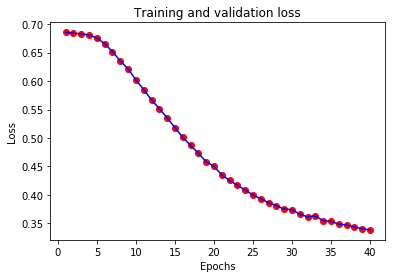

In [810]:
accuracy = history['acc']
validation_accuracy = history['val_acc']
loss = history['val_loss']
validation_loss = history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'ro', label="Training loss")
plt.plot(epochs, validation_loss, 'b', label="Validation loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend

plt.show()

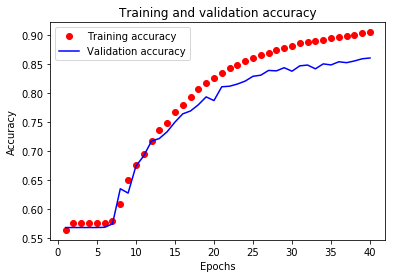

In [812]:
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
#currently overfitting